In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import os
import seaborn as sb
import shutil
import soundfile as sf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

The **ESC-50 dataset** is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Door knock</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> | <sub>Mouse click</sub> | <sub>Chainsaw</sub> |
| <sub>Pig</sub> | <sub>Crackling fire</sub> | <sub>Clapping</sub> | <sub>Keyboard typing</sub> | <sub>Siren</sub> |
| <sub>Cow</sub> | <sub>Crickets</sub> | <sub>Breathing</sub> | <sub>Door, wood creaks</sub> | <sub>Car horn</sub> |
| <sub>Frog</sub> | <sub>Chirping birds</sub> | <sub>Coughing</sub> | <sub>Can opening</sub> | <sub>Engine</sub> |
| <sub>Cat</sub> | <sub>Water drops</sub> | <sub>Footsteps</sub> | <sub>Washing machine</sub> | <sub>Train</sub> |
| <sub>Hen</sub> | <sub>Wind</sub> | <sub>Laughing</sub> | <sub>Vacuum cleaner</sub> | <sub>Church bells</sub> |
| <sub>Insects (flying)</sub> | <sub>Pouring water</sub> | <sub>Brushing teeth</sub> | <sub>Clock alarm</sub> | <sub>Airplane</sub> |
| <sub>Sheep</sub> | <sub>Toilet flush</sub> | <sub>Snoring</sub> | <sub>Clock tick</sub> | <sub>Fireworks</sub> |
| <sub>Crow</sub> | <sub>Thunderstorm</sub> | <sub>Drinking, sipping</sub> | <sub>Glass breaking</sub> | <sub>Hand saw</sub> |

In [2]:
metadata = pd.read_csv('ESC-50-master/meta/esc50.csv')

metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [3]:
metadata = metadata[['category','filename']].copy()

metadata.head()

,category,filename
0,dog,1-100032-A-0.wav
1,chirping_birds,1-100038-A-14.wav
2,vacuum_cleaner,1-100210-A-36.wav
3,vacuum_cleaner,1-100210-B-36.wav
4,thunderstorm,1-101296-A-19.wav


In [4]:
metadata['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [5]:
metadata.shape

(2000, 2)

In [6]:
animal_categories = [
    'dog',
    'chirping_birds',
    'crow','sheep',
    'frog',
    'cow',
    'insects',
    'hen',
    'pig',
    'rooster',
    'cat'
]

# animal_metadata = metadata[metadata['category'].isin(animal_categories)]

# animal_metadata['category'].unique()




create folder if does not exist

In [7]:
folder_path = 'cleaned_audio'
clean_data_file_path = 'cleaned_metadata.csv'
skip_delete = os.path.exists(clean_data_file_path)

# Check if the folder does not exist
if not os.path.exists(folder_path):
    # Create the folder
    os.makedirs(folder_path)
    result = f"Folder '{folder_path}' was created."
else:
    # If skip_delete is False, delete everything in the folder
    if not skip_delete:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.pcleath.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                result = f'Failed to delete {file_path}. Reason: {e}'
        result = f"Existing contents of '{folder_path}' have been deleted."
    else:
        result = "Skipping deletion as per 'skip_delete' flag."

result



"Skipping deletion as per 'skip_delete' flag."

In [8]:
source_directory = 'ESC-50-master/audio'

def adjust_volume(data, volume_change):
    return data * volume_change

if not skip_delete:
    for index, row in metadata.iterrows():
        filename = row['filename']
        category = row['category']

        #Copy original file over
        source_file = os.path.join(source_directory, filename)
        destination_file = os.path.join(folder_path, filename)
        shutil.copy2(source_file, destination_file)

        try:
            y, sr = librosa.load(source_file, sr=None)

            #Adjust volumes
            y_higher = adjust_volume(y,2)
            y_lower = adjust_volume(y,0.5)

            #Generate new filenames
            base, ext = os.path.splitext(filename)
            higher_volume_filename = f"{base}_higher{ext}"
            lower_volume_filename = f"{base}_lower{ext}"

            #Save the adjusted audio files
            higher_file_path = os.path.join(folder_path, higher_volume_filename)
            lower_file_path = os.path.join(folder_path, lower_volume_filename)
            sf.write(higher_file_path, y_higher, sr)
            sf.write(lower_file_path, y_lower, sr)

            # Add new entries to the dataframe
            new_rows = [
                {'category': category, 'filename': higher_volume_filename},
                {'category': category, 'filename': lower_volume_filename}
            ]
            metadata = pd.concat([metadata, pd.DataFrame(new_rows)], ignore_index=True)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

        result = "Files copied successfully."
else:
    result = "Skipping file copying and manipulation as per 'skip_delete' flag."

result

"Skipping file copying and manipulation as per 'skip_delete' flag."

In [9]:
metadata.shape

(2000, 2)

# Animal Sound Classification Features Overview (NEED TO MOVE THIS)

## 1. Mel-frequency Cepstral Coefficients (MFCCs)
- **Why?** MFCCs are very effective in capturing the timbral aspects of sound. They've been widely used in speech recognition and can differentiate various types of sounds including animal vocalizations. The coefficients effectively capture the rate changes in spectral bands and are useful for identifying different kinds of animal sounds.

## 2. Spectral Features
- **Spectral Centroid:** Useful for identifying the "brightness" of a sound, which can differentiate between high-pitched and low-pitched animal calls.
- **Spectral Bandwidth:** Provides information about the spread of the spectrum, which can help distinguish between broad and narrow-band sounds.
- **Spectral Contrast:** Useful for identifying different sound textures and can help differentiate between sounds in different environments or contexts.
- **Spectral Rolloff:** Indicates the frequency below which a certain percentage of the total spectral energy is contained. It can be used to distinguish between harmonic (musical) and inharmonic sounds.

## 3. Chroma Features
- **Chroma STFT:** Captures the harmonic content of audio which might be useful for some species where the harmonic structure of the sound is important for classification.

## 4. Rhythm Features
- **Tempo:** While not always directly applicable to animal sounds, the tempo can be useful in contexts where the rhythm of sounds (like the repetitive calls of some species) plays a role in identification.

## 5. Zero-Crossing Rate (ZCR)
- **Why?** It measures the rate of sign changes along a signal. Useful for distinguishing between percussive sounds and more sustained sounds. Animal calls often have distinctive patterns that can be captured by ZCR.

## 6. Root Mean Square (RMS) Energy
- **Why?** It provides a measure of the sound's energy over time. For animal sound classification, variations in energy can help differentiate between vocalizations.

## 7. Time-domain Features
- Although less common than frequency-domain features for this type of classification, features like waveform shape and amplitude envelope could provide useful insights into the dynamics of animal vocalizations.


In [10]:
# Define the feature names with the new meaningful names
feature_names = (
['Spectral_Energy', 'Spectral_Shape_1', 'Spectral_Shape_2', 'Spectral_Shape_3',
    'Fine_Spectral_Texture_1', 'Fine_Spectral_Texture_2', 'Fine_Spectral_Texture_3',
    'Fine_Timbral_Detail_1', 'Fine_Timbral_Detail_2', 'Fine_Timbral_Detail_3',
    'Subtle_Timbral_Variation_1', 'Subtle_Timbral_Variation_2', 'Subtle_Timbral_Variation_3'] +
['Spectral_Centroid', 'Spectral_Bandwidth'] +
['Low_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 'Mid_Frequency_Contrast',
'Mid_High_Frequency_Contrast', 'High_Frequency_Contrast', 'Very_High_Frequency_Contrast',
'Extreme_High_Frequency_Contrast'] 
+
['Spectral_Rolloff'] +
['Chroma_C', 'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E',
    'Chroma_F', 'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'Chroma_A', 'Chroma_A#', 'Chroma_B'] +
['Zero_Crossing_Rate', 'RMS_Energy']
)

# Define the function to extract audio features
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        rms_energy = np.mean(librosa.feature.rms(y=y))
        features = np.hstack((mfccs, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, chroma_stft, zero_crossing_rate, rms_energy))
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [np.nan]*37  # Adjust for the total number of features

if os.path.exists(clean_data_file_path):
    metadata = pd.read_csv(clean_data_file_path)
else:
    # Prepare to collect the features
    features = []

    # Extract features for each audio file in the DataFrame
    for _, row in metadata.iterrows():
        filename = row['filename']
        source_file = os.path.join(folder_path, filename)
        try:
            features.append(extract_features(source_file))
        except Exception as e:
            print(f"Error processing {source_file}: {e}")
            features.append([np.nan]*37)  # Adjust for the total number of features

    # Convert the list of features to a DataFrame
    features_df = pd.DataFrame(features, columns=feature_names)

    # Concatenate with the original DataFrame (check alignment)
    metadata = pd.concat([metadata.reset_index(drop=True), features_df], axis=1)

    # Save the updated DataFrame to CSV
    metadata.to_csv(clean_data_file_path, index=False)

In [11]:
metadata = metadata.sort_values(by='filename')
metadata.head()

,category,filename,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,...,Chroma_E,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy
0,dog,1-100032-A-0.wav,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,...,0.015058,0.018501,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518
2000,dog,1-100032-A-0_higher.wav,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,...,0.015134,0.018785,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233
2001,dog,1-100032-A-0_lower.wav,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,...,0.014341,0.017798,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759
1,chirping_birds,1-100038-A-14.wav,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,...,0.358096,0.370746,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115
2002,chirping_birds,1-100038-A-14_higher.wav,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,...,0.358095,0.370746,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224


In [12]:
metadata['is_animal'] = np.where(metadata['category'].isin(animal_categories), 1, 0)
metadata.head()

,category,filename,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,...,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal
0,dog,1-100032-A-0.wav,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,...,0.018501,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1
2000,dog,1-100032-A-0_higher.wav,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,...,0.018785,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1
2001,dog,1-100032-A-0_lower.wav,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,...,0.017798,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1
1,chirping_birds,1-100038-A-14.wav,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,...,0.370746,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1
2002,chirping_birds,1-100038-A-14_higher.wav,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,...,0.370746,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1


In [13]:
cleaned_metadata = metadata.drop(columns=['filename','category'])
cleaned_metadata.head()

,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,Fine_Timbral_Detail_2,Fine_Timbral_Detail_3,...,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal
0,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,0.518284,0.341884,...,0.018501,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1
2000,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,0.604016,0.566948,...,0.018785,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1
2001,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,0.520418,0.343702,...,0.017798,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1
1,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,-11.705071,-17.621454,...,0.370746,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1
2002,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,-11.573458,-17.572086,...,0.370746,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1


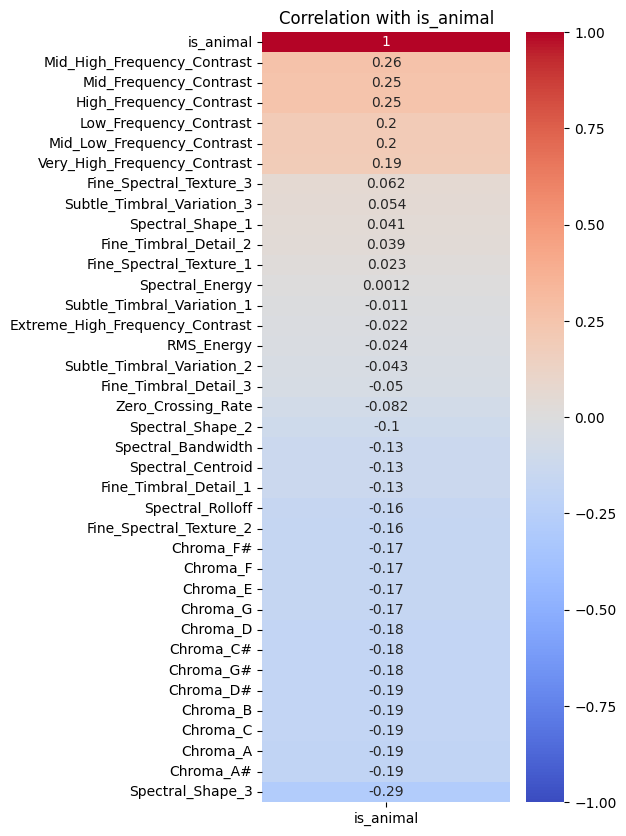

In [14]:
corr_matrix = cleaned_metadata.corr()

# Focus on the 'is_animal' correlations
corr_with_is_animal = corr_matrix[['is_animal']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_animal.sort_values(by='is_animal', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with is_animal')

# Show the plot
plt.show()

In [15]:
# Map categories to numerical values
category_mapping = {category: index + 1 for index, category in enumerate(animal_categories)}

# Add numerical values to the DataFrame
metadata['category_numeric'] = metadata['category'].map(category_mapping)

#remove the non-numerical columns
cleaned_metadata1 = metadata.drop(columns=['filename', 'category'])

cleaned_metadata1.head()

,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,Fine_Timbral_Detail_2,Fine_Timbral_Detail_3,...,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal,category_numeric
0,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,0.518284,0.341884,...,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1,1.0
2000,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,0.604016,0.566948,...,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1,1.0
2001,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,0.520418,0.343702,...,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1,1.0
1,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,-11.705071,-17.621454,...,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1,2.0
2002,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,-11.573458,-17.572086,...,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1,2.0


In [16]:
# Identifying important features to determine whether sound is made by an animal
important_features_1 = ['Spectral_Shape_3', 'Low_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 'Mid_Frequency_Contrast',
'Mid_High_Frequency_Contrast', 'High_Frequency_Contrast', 'Very_High_Frequency_Contrast',
'Extreme_High_Frequency_Contrast'] + ['Chroma_C', 'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E',
    'Chroma_F', 'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'Chroma_A', 'Chroma_A#', 'Chroma_B']

In [17]:
animal_metadata = metadata[metadata['category'].isin(animal_categories)]
animal_metadata.head()

,category,filename,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,...,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal,category_numeric
0,dog,1-100032-A-0.wav,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,...,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1,1.0
2000,dog,1-100032-A-0_higher.wav,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,...,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1,1.0
2001,dog,1-100032-A-0_lower.wav,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,...,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1,1.0
1,chirping_birds,1-100038-A-14.wav,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,...,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1,2.0
2002,chirping_birds,1-100038-A-14_higher.wav,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,...,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1,2.0


In [18]:
animal_metadata_clean = animal_metadata.drop(columns=['filename'])
animal_metadata_encoded = pd.get_dummies(animal_metadata_clean, columns=['category'])

animal_dataframes = {}

# Loop through each animal category to create a separate DataFrame
for animal in animal_categories:
    # Define the column for the current animal
    animal_column = f'category_{animal}'
    
    # Identify non-category specific columns (i.e., those not starting with 'category_')
    non_category_columns = [col for col in animal_metadata_encoded.columns if not col.startswith('category_')]
    
    # Define columns to keep: non-animal specific + current animal's column
    columns_to_keep = non_category_columns + [animal_column]
    
    # Create a new DataFrame with only the desired columns
    animal_df = animal_metadata_encoded[columns_to_keep].copy()
    
    # Add the new DataFrame to the dictionary with a key for the animal name
    animal_dataframes[animal] = animal_df.drop(columns=['is_animal'])

## Correlation between audio features and dogs

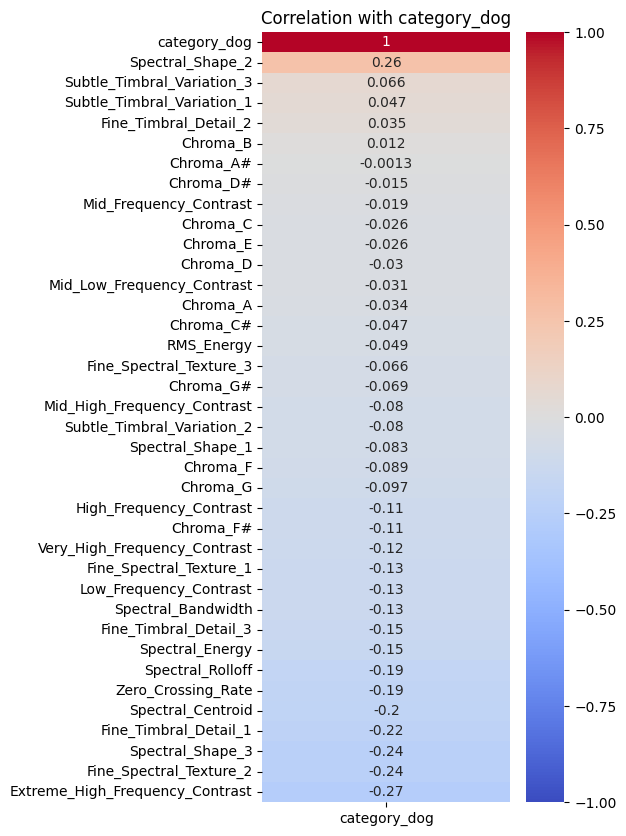

In [19]:
#Correlation for dog
corr_matrix_dog = animal_dataframes['dog'].corr()

# Focus on the 'is_animal' correlations
corr_with_is_dog = corr_matrix_dog[['category_dog']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_dog.sort_values(by='category_dog', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_dog')

# Show the plot
plt.show()

In [20]:
# #Comparing important audio feature to different types of animals
# animal_metadata_important = animal_metadata.filter(important_features_1+['category'])

# animal_metadata_important_encoded = pd.get_dummies(animal_metadata_important, columns=['category'])
# correlations_important= animal_metadata_important_encoded.corr()

# # Plotting a heatmap
# plt.figure(figsize=(12, 10))
# sb.heatmap(correlations_important, 
#             cmap='coolwarm', 
#             center=0, 
#             annot=False,  # You can set this to True if you want to see the correlation values
#             fmt=".2f",    # Formatting the annotation if annot=True
#             linewidths=.5,
#             cbar_kws={'shrink': .5, 'label': 'Correlation coefficient'})
# plt.title('Correlation Heatmap between important Audio Features and Animal Categories')
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [21]:
# # Identifying important features to find out which animal made that sound
# feature_important_columns = [col for col in animal_metadata_important_encoded.columns if not col.startswith('category_')]
# category_important_columns = [col for col in animal_metadata_important_encoded.columns if col.startswith('category_')]

# feature_to_category_corr = correlations_important.loc[feature_important_columns, category_important_columns]

# mean_abs_corr_per_feature = feature_to_category_corr.abs().mean(axis=1)

# # Plotting a bar plot for the mean absolute correlation of each feature with categories
# plt.figure(figsize=(12, 6))
# mean_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
# plt.title('Mean Absolute Correlation of Each Feature with Categories')
# plt.ylabel('Mean Absolute Correlation with Categories')
# plt.xlabel('Features')
# plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
# plt.tight_layout()
# plt.show()

# important_features_2 = ['Mid_High_Frequency_Contrast','Spectral_Shape_3','Mid_Frequency_Contrast','High_Frequency_Contrast','Mid_Low_Frequency_Contrast']

In [24]:
correlations = animal_metadata_encoded.corr()

# # Plotting a heatmap
# plt.figure(figsize=(12, 10))
# sb.heatmap(correlations, 
#             cmap='coolwarm', 
#             center=0, 
#             annot=False,  # You can set this to True if you want to see the correlation values
#             fmt=".2f",    # Formatting the annotation if annot=True
#             linewidths=.5,
#             cbar_kws={'shrink': .5, 'label': 'Correlation coefficient'})
# plt.title('Correlation Heatmap between Audio Features and Animal Categories')
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# Max Absolute Correlation of Each Feature with Categories

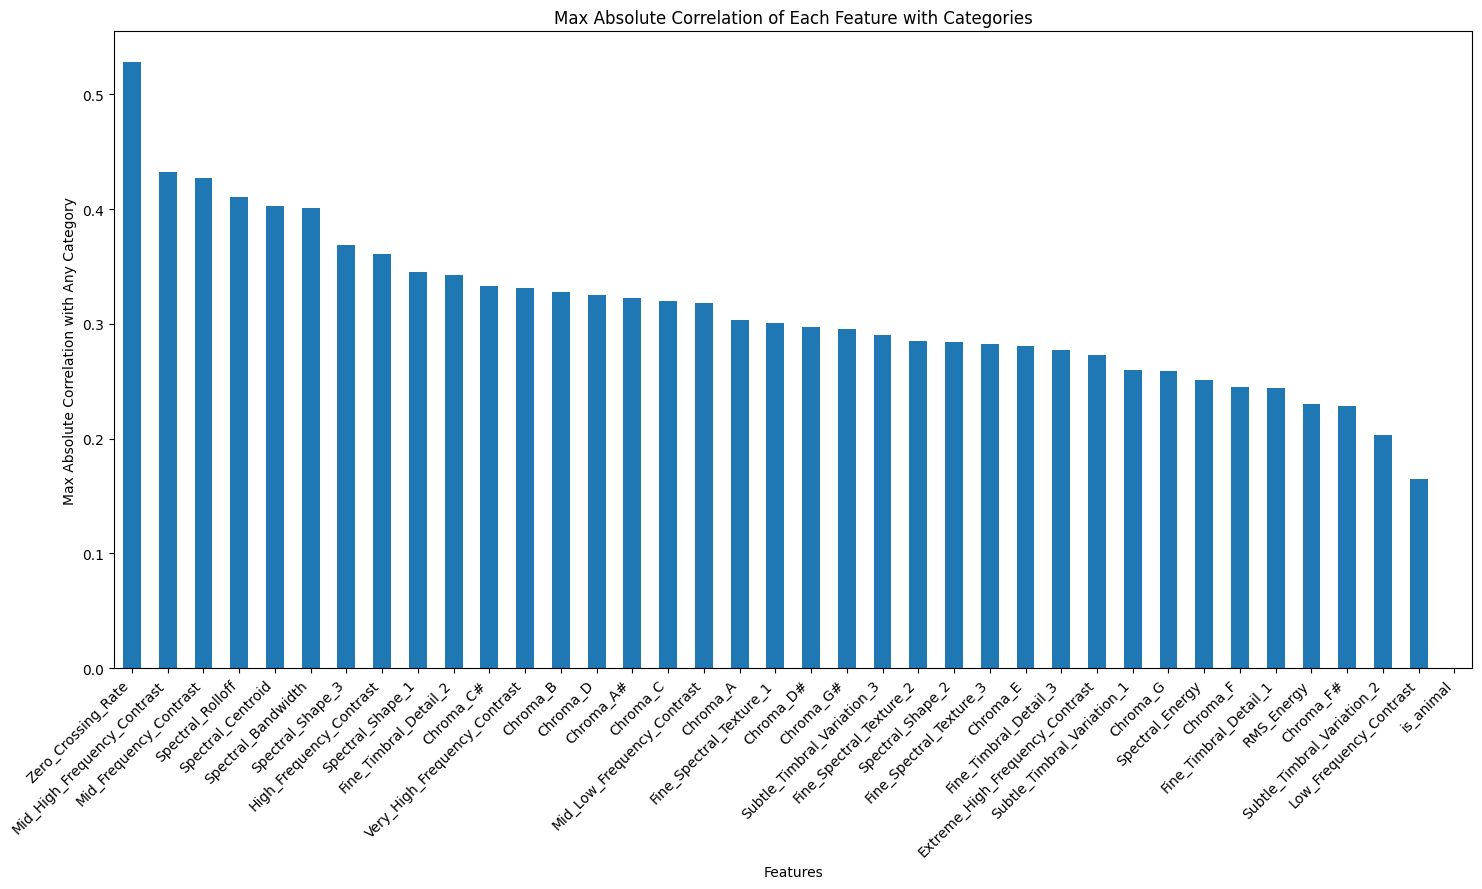

In [25]:

feature_columns = [col for col in animal_metadata_encoded.columns if not col.startswith('category_')]
category_columns = [col for col in animal_metadata_encoded.columns if col.startswith('category_')]

# Now, extract the correlations between features and categories directly
feature_to_category_corr = correlations.loc[feature_columns, category_columns]

# Calculate the maximum absolute correlation for each feature
max_abs_corr_per_feature = feature_to_category_corr.abs().max(axis=1)

# Plotting a bar plot for the summary statistic of each feature
plt.figure(figsize=(15, 9))
max_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
plt.title('Max Absolute Correlation of Each Feature with Categories')
plt.ylabel('Max Absolute Correlation with Any Category')
plt.xlabel('Features')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.tight_layout()
plt.show()


# Mean Absoulte Correlation Per Feature

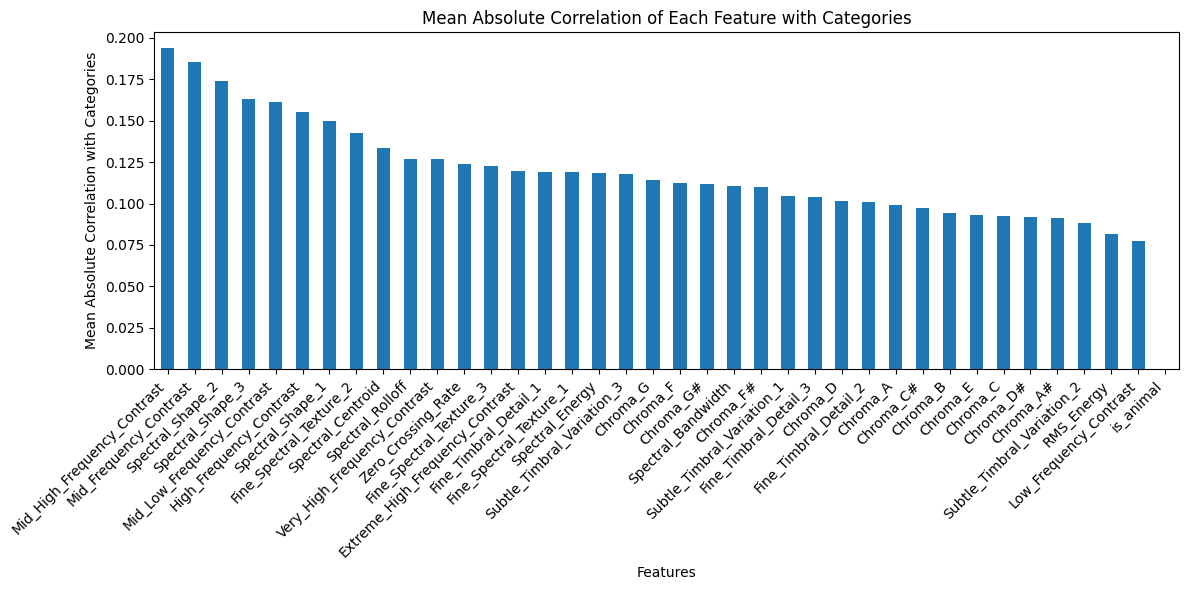

In [26]:
mean_abs_corr_per_feature = feature_to_category_corr.abs().mean(axis=1)

# Plotting a bar plot for the mean absolute correlation of each feature with categories
plt.figure(figsize=(12, 6))
mean_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
plt.title('Mean Absolute Correlation of Each Feature with Categories')
plt.ylabel('Mean Absolute Correlation with Categories')
plt.xlabel('Features')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.tight_layout()
plt.show()

# Boxplot analysis of Spectral Energy

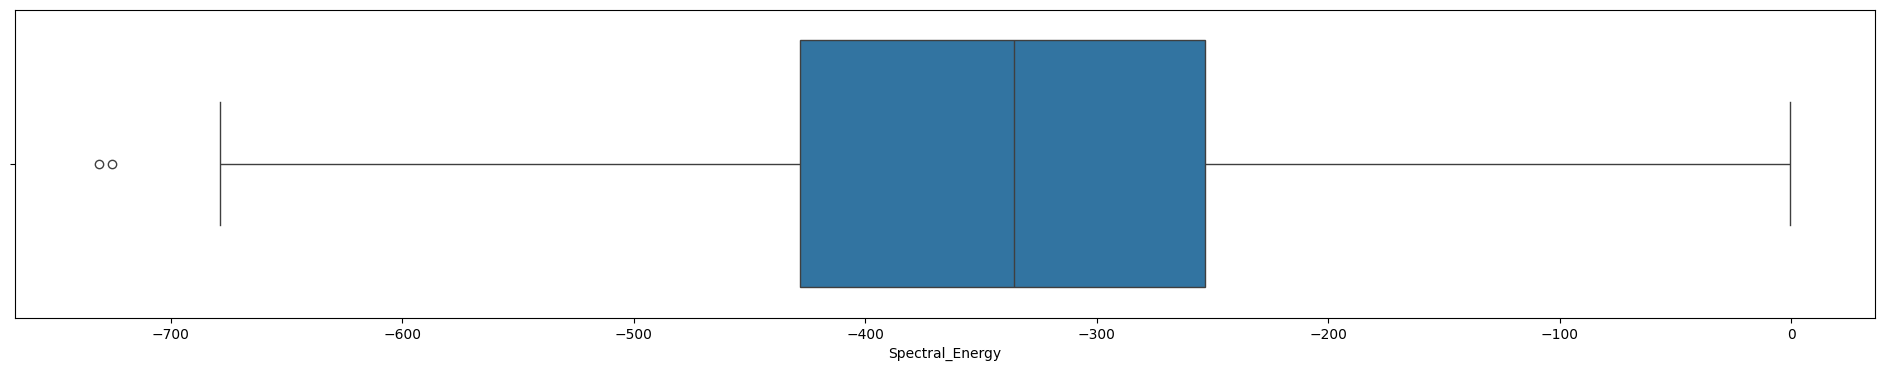

In [27]:
# Assuming 'animal_metadata_encoded' is your DataFrame and it contains a 'Spectral_Energy' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata_encoded['Spectral_Energy'], orient="h")
plt.show()


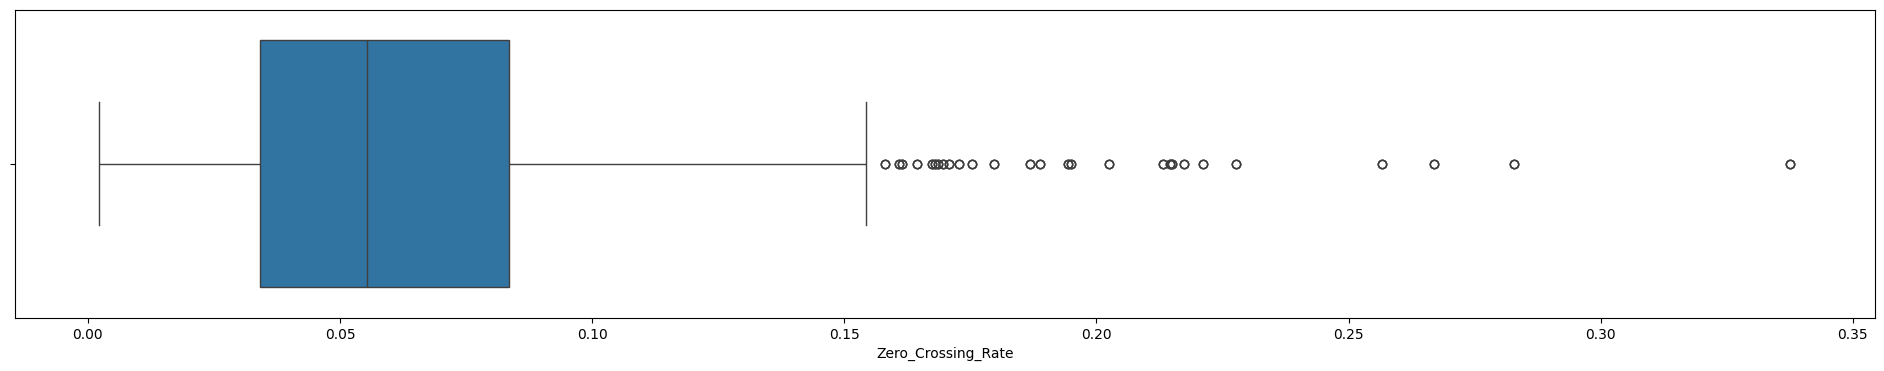

In [28]:
# Assuming 'animal_metadata_encoded' is your DataFrame and it contains a 'Spectral_Energy' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata_encoded['Zero_Crossing_Rate'], orient="h")
plt.show()

In [30]:
# # Changing all non-animal category to the same name
# non_animal = metadata.copy()
# non_animal_mask = ~non_animal['category'].isin(animal_categories)
# non_animal.loc[non_animal_mask, 'category'] = 'non-animal'

# # Training AI to identify whether the sound is made by an animal and what type of animal it is from the important categories
# X = non_animal[important_features_2]  # Feature matrix
# y = non_animal['category']  # Original labels

# # Initialize and fit the label encoder
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)  # Transform labels to numerical values

# # Correctly split the data into training and testing sets using encoded labels
# X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=50)

# # Initialize the XGBoost classifier
# model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

# # Train the model using encoded labels
# model.fit(X_train, y_train_encoded)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Calculate the accuracy using the encoded test labels
# accuracy = accuracy_score(y_test_encoded, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

In [31]:
X = animal_metadata[feature_names]  # Feature matrix
y = animal_metadata['category']  # Original labels

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform labels to numerical values

# Correctly split the data into training and testing sets using encoded labels
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=50)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

# Train the model using encoded labels
model.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy using the encoded test labels
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.11%
